In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interactive
import seaborn as sb
import glob

In [2]:
shot_data = glob.glob("/Users/coreyhuang/Documents/Data Science Stuff/NBA Shooting Score Analysis/NBA shot log 16-17-regular season/Shot data/*.csv")
player__df = pd.read_csv("/Users/coreyhuang/Documents/Data Science Stuff/NBA Shooting Score Analysis/NBA shot log 16-17-regular season/Player Regular 16-17 Stats.csv")
schedule_df = pd.read_csv("/Users/coreyhuang/Documents/Data Science Stuff/NBA Shooting Score Analysis/NBA shot log 16-17-regular season/Game Schedule 16-17-Regular.csv")

In [3]:
shot_data_tmp = []
for csvfile in shot_data:
    df = pd.read_csv(csvfile)
    shot_data_tmp.append(df)

In [4]:
shot_df = pd.concat(shot_data_tmp, axis = 0, ignore_index = True)

In [5]:
# Remove NaN
shot_df = pd.DataFrame(shot_df)

shot_df = shot_df.dropna(subset=['location x'])
shot_df = shot_df.reset_index(drop=True)

In [6]:
shot_df.head(3)

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,time,date,shoot player,time from last shot,quarter,current shot outcome
0,NaN,PF,Yes,107.0,SCORED,PHX,Floating Jump Shot,2,SAC,252.0,0:51,2016-10-26,Jared Dudley,NaN,1,SCORED
1,SCORED,SG,Yes,254.0,MISSED,PHX,Jump Shot,3,SAC,56.0,1:14,2016-10-26,Devin Booker,23.0,1,MISSED
2,MISSED,C,Yes,52.0,SCORED,PHX,Cutting Dunk Shot,2,SAC,250.0,1:44,2016-10-26,Tyson Chandler,30.0,1,SCORED


## Create Basketball Court

In [7]:
def create_court(ax, color):
    # Short corner 3-pt line
    ax.plot([30, 30], [0, 140], linewidth=2, color=color)
    ax.plot([470, 470], [0, 140], linewidth=2, color=color)
    
    # 3-pt Arc
    ax.add_artist(mpl.patches.Arc((250, 140), 440, 315, theta1=0, theta2=180, 
                                  facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([170, 170], [0, 190], linewidth=2, color=color)
    ax.plot([330, 330], [0, 190], linewidth=2, color=color)
    ax.plot([190, 190], [0, 190], linewidth=2, color=color)
    ax.plot([310, 310], [0, 190], linewidth=2, color=color)
    ax.plot([170, 330], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((250, 190), 60, facecolor='none', edgecolor=color, lw=2))
    
    # Rim
    ax.add_artist(mpl.patches.Circle((250, 60), 15, facecolor='none', edgecolor=color, lw=2))
    
    # Backboard
    ax.plot([220, 280], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 470)

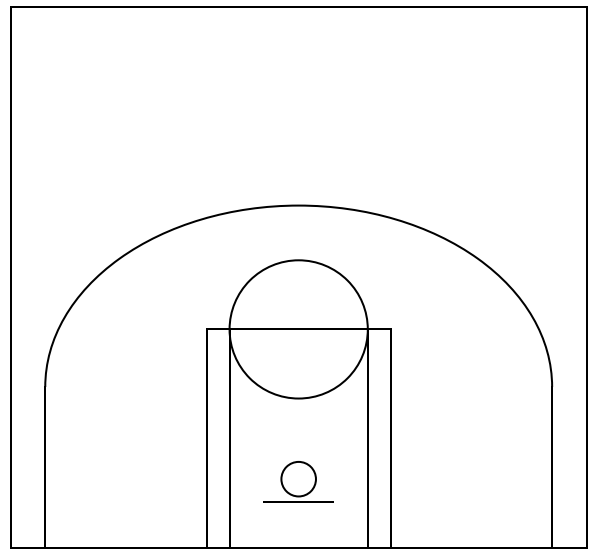

In [8]:
# General plot parameters
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 1
mpl.rcParams['axes.linewidth'] = 2

# Draw basketball court
fig = plt.figure(figsize=(8, 7.52))
ax = fig.add_axes([0, 0, 1, 1])

create_court(ax, 'black')
plt.show()

## Modify Data Frame to Plot on a Halfcourt

In [9]:
## Create new dataframe for a HALFCOURT heat map:
# Copy shot_df, swap location x and y columns
heatmap_df = shot_df.copy()
heatmap_df.rename(columns={'location x':'location y', 'location y':'location x'}, inplace=True)

In [10]:
# Create functions to rescale location for half-court diagram
def change_y(num):
    if num > 470:
        num = 940 - num
        return num
    else:
        return num

def change_x(num):
    if num < 250:
        num = 500 - num
        return num
    elif num > 250:
        num = 500 - num
        return num
    else:
        return num
    
# Update x and y coordinates
heatmap_df['location y'] = heatmap_df['location y'].apply(change_y)
heatmap_df['location x'] = heatmap_df['location x'].apply(change_x)

## Shots Attempted vs. Shots Made Heat Map

This heat map shows the distribution of shots in different areas on the court.

In [29]:
# Create test data - Devin Booker

# Shots attempted
test_df = heatmap_df.loc[heatmap_df['shoot player'] == 'Devin Booker']

# Shots made
test_scored_df = test_df.loc[heatmap_df['current shot outcome'] == "SCORED"]

In [ ]:
# Ask for Player
# def filter_player(player):
    # heatmap_df.loc[heatmap_df['shoot player'] == player]

In [53]:
def heatmap(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="white", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    create_court(ax, 'white')
    
    x = data['location x']
    y = data['location y']
    
    sb.kdeplot(x, y, shade=True, cmap='inferno', ax=ax, **kwargs)

    ax.scatter(x, y, facecolors='w', s=2, linewidths=0.1, **kwargs)
    
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

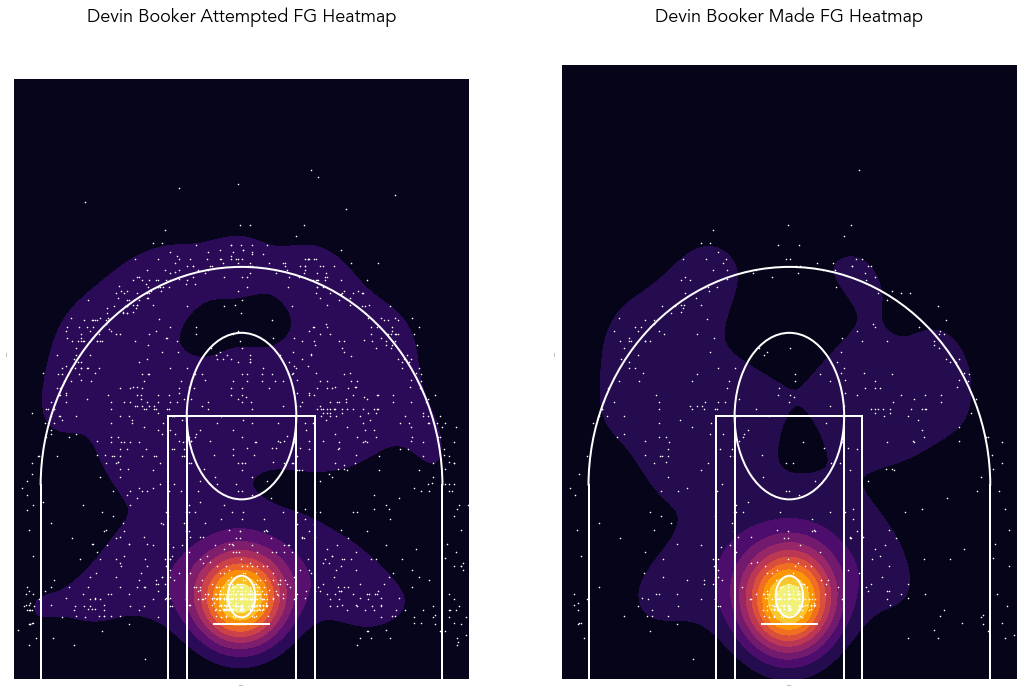

In [57]:
ax = fig.add_axes([0, 0, 1, 1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,12))

heatmap(test_df, "Devin Booker Attempted FG Heatmap", ax=ax1)
heatmap(test_scored_df, "Devin Booker Made FG Heatmap", ax=ax2)
plt.show()

## Shots Made Heat Map

This heat map shows the type of shot attempted and its location.